In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy.ndimage as ndi
rc("image", origin="lower", cmap="gray", interpolation="bicubic")

Bayesian Decision Theory
=======================

## Joint Density

In decision problems, we have items with:

- some measurable property/properties $x\in R^n$
- some class $\omega\in \{0,...,C\}$

These are described by a _joint density_ $P(\omega,x)$.

## Conditional Densities

The _class conditional density_ is $p(x|\omega) = P(\omega,x) / P(\omega)$.

The _posterior distribution_ is $P(\omega|x) = P(\omega,x) / p(x)$.

## Bayes Rule

These two combine into _Bayes Rule_:

$$p(x|\omega) P(\omega) = P(\omega|x) p(x)$$

or

$$P(\omega|x) = \frac{p(x|\omega) P(\omega)}{p(x)}$$

## Optimal Decision Rule

The _optimal decision rule_ under a zero-one loss function is 

$D(x) = \arg\max_\omega P(\omega|x)$

## Justification for Optimal Decision Rule

The reason for this is that the probability of error for each $x$ is

$$P(\hbox{error}|x) = 1 - \max_\omega P(\omega|x)$$ 

and the total error is given by:

$$P(\hbox{error}) = \int P(\hbox{error}|x) p(x) dx $$

The generalization of minimizing $P(\hbox{error})$ is minimizing expected loss; see below.

## Is Bayesian Decision Theory optimizing "the right thing"?

Common objections:

- We don't have a prior, so Bayesian Decision Theory isn't applicable.
- We don't want to minimize expected error/loss, but something else (e.g., worst case performance).

## Is Bayesian Decision Theory optimizing "the right thing"?

Mathematical results:

- Every decision procedure is either Bayesian for some (unstated) prior, or it is provably "bad".
- Maximum ignorance can be expressed via "uninformative priors".
- Minimax decision rules like "best worst case" are captured by loss functions (later).

## Is Bayesian Decision Theory optimizing "the right thing"?

$P(\hbox{error})$ and derived measures naturally correspond to what actually matters in many applications:

- self driving cars: minimize the probability of error (with asymmetric losses)
- financial markets: maximize the long term return
- medical diagnoses: minimize the probability of error (with asymmetric losses)
- ...

## How is this relevant to Deep Learning?

Because...

**Deep learning estimates posterior probabilities.**

That is, deep learning-based classifiers take training data and produce a function $f(x)$ that yields an estimate of a posterior probability for each class.

(We'll see this again later.)

In [3]:
from scipy import stats
from scipy.stats import norm

# Bayesian Decision Theory

Let's do a Bayesian decision theoretic calculation twice.

First, we assume that we know the densities perfectly (no estimation problem) and look at the 1D case.

Second, we repeat this, but this time estimating densities using kernel density estimation in 2D.

## Class Conditional Densities

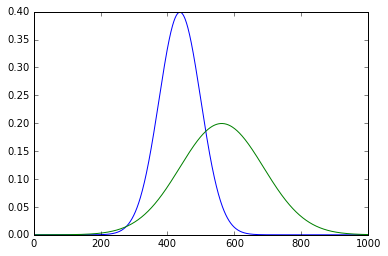

In [4]:
x = linspace(-8.0,8.0,1000)
p_x_given_1 = norm.pdf(x,loc=-1.0)
p_x_given_2 = norm.pdf(x,loc=1.0,scale=2.0)
plot(p_x_given_1); plot(p_x_given_2)

## Priors and Sample Distribution

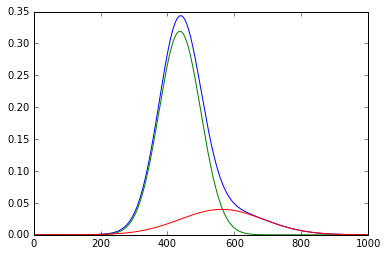

In [5]:
p_1 = 0.8
p_2 = 0.2
p_x = p_x_given_1 * p_1 + p_x_given_2 * p_2
plot(p_x); plot(p_x_given_1*p_1); plot(p_x_given_2*p_2)

## Conditional Distributions

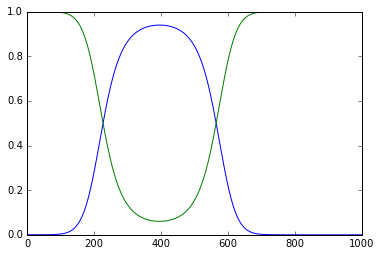

In [6]:
p_1_given_x = p_x_given_1 * p_1 / p_x
p_2_given_x = p_x_given_2 * p_2 / p_x
plot(p_1_given_x); plot(p_2_given_x)

## Error at Each Point

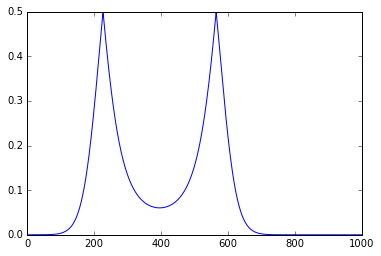

In [7]:
p_error_given_x = 1-maximum(p_1_given_x,p_2_given_x)
plot(p_error_given_x)

## Bayes Error

In [8]:
print sum(p_error_given_x*p_x)/sum(p_x)

0.11771583842133666


An important property of _all decision problems_ is that they have an intrinsic error rate called the _Bayes error_.

No classifier, neural network, human, etc. can do better than the Bayes error in the long run.

# 2D Example with Sampling

In [9]:
from scipy.stats import multivariate_normal as mvn

In [10]:
def plot_samples(s1, s2):
    figsize(6,6); xlim([0,100]); ylim([0, 100])
    scatter(*s1.T, color="blue", alpha=0.3)
    scatter(*s2.T, color="red", alpha=0.3)

## Classification Problem from Samples

To illustrate Bayesian decision theory on real data, let's start with training data and go through the whole process of estimating densities and posteriors.

(By the way, this is a multivariate normal classification problem, for which closed form solutions for the optimal decision boundaries are known. If you don't know those solutions, look them up.)

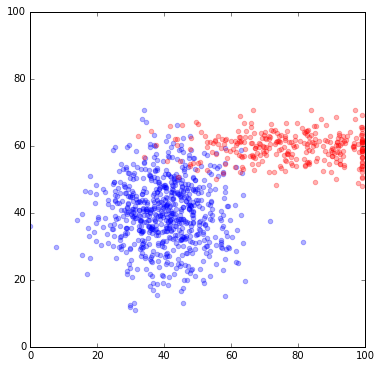

In [11]:
s1 = samples_from_class1 = clip(mvn.rvs([40.0, 40.0], diag([100.0, 100.0]), size=700), 0, 99)
s2 = samples_from_class1 = clip(mvn.rvs([80.0, 60.0], diag([300.0, 20.0]), size=300), 0, 99)
plot_samples(s1, s2)

## Prior Probabilities

The prior probabilities of each class are simply estimated by counting.

In [12]:
p_1 = len(s1) / float(len(s1) + len(s2))
p_2 = len(s2) / float(len(s1) + len(s2))

## Samples in 2D

We have continuous samples in this classification problem, but we're going to perform a simple form of kernel density estimation (similar to RBF and fully connected neural networks). 

To illustrate the distributions, we are going to do this estimate on actual images. 

The scale of the problem has been adjusted so that this works easily with integer coordinates.

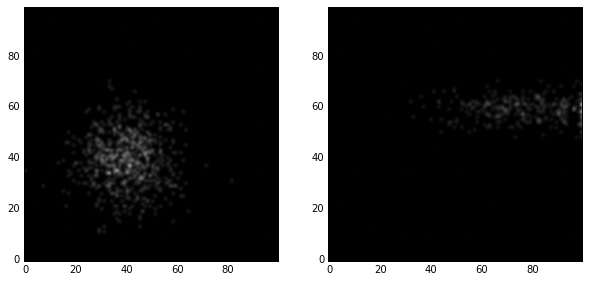

In [13]:
def samples2image(samples):
    image = zeros((100, 100))
    for x, y in samples:
        image[int(y), int(x)] += 1
    return image

figsize(10, 5); subplot(121); imshow(samples2image(s1)); subplot(122); imshow(samples2image(s2))

## Kernel Density Estimation

After placing our samples into an image, kernel density estimation reduces to a Gaussian filter. 

The image intensity (after normalization) corresponds to the class conditional density.

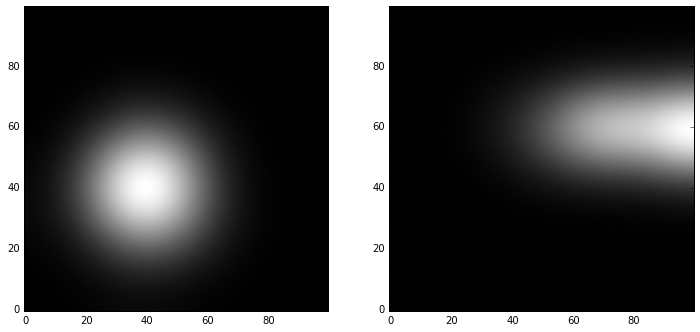

In [14]:
p_x_given_1 = ndi.gaussian_filter(samples2image(s1), 10.0); p_x_given_1 /= sum(p_x_given_1)
p_x_given_2 = ndi.gaussian_filter(samples2image(s2), 10.0); p_x_given_2 /= sum(p_x_given_2)
figsize(12, 6); subplot(121); imshow(p_x_given_1); subplot(122); imshow(p_x_given_2)

## Empirical vs Actual Distributions

It is very important to keep in mind that we have two distinct distributions:
    
- the true class-conditional densities $p(x|\omega)$
- our _estimates_ of these densities $\hat{p}(x|\omega)$.

For any reasonable decision procedure, we want $\hat{p}(x|\omega) \rightarrow p(x|\omega)$ as the number of training samples goes to infinity.

However, any result derived from $\hat{p}$ can be wildly wrong.

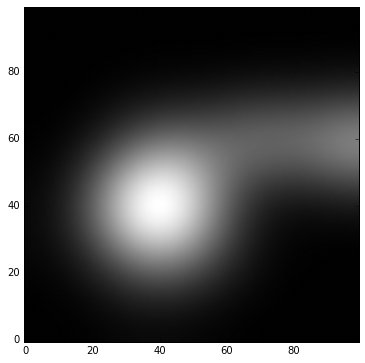

In [15]:
# sample distribution
p_x = p_x_given_1 * p_1 + p_x_given_2 * p_2
imshow(p_x)

6569.756814982116 3430.2431850178837 <--- not densities


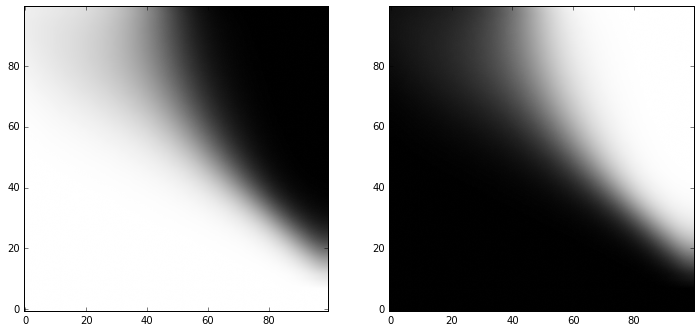

In [16]:
# posterior probabilities
p_1_given_x = p_x_given_1 * p_1 / p_x
p_2_given_x = p_x_given_2 * p_2 / p_x
subplot(121); imshow(p_1_given_x); subplot(122); imshow(p_2_given_x)
print sum(p_1_given_x), sum(p_2_given_x), "<--- not densities"

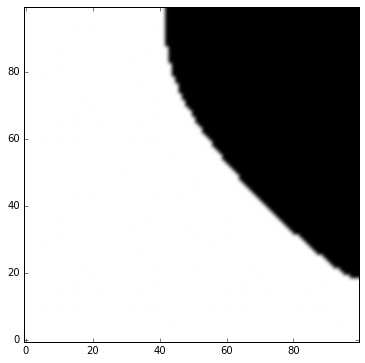

In [17]:
# Decision Regions
dr1 = (p_1_given_x > p_2_given_x)
dr2 = (p_2_given_x >= p_1_given_x)
imshow(dr1)

0.07686342001843093


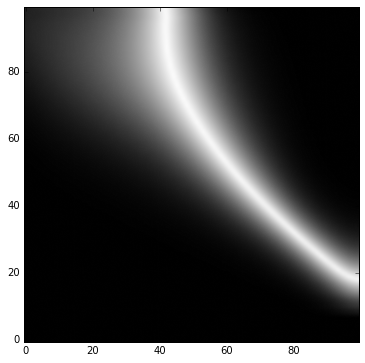

In [18]:
# P(error|x) and Bayes error rate estimate
imshow(1-maximum(p_1_given_x, p_2_given_x))
print sum((1-maximum(p_1_given_x, p_2_given_x))*p_x)

## Different Error Estimates

Note that there are several different ways of computing the error rate:

- true Bayes error (from the actual distributions)
- Bayes error from the empirial distribution models
- training set error (computed from sample and decision rule)
- test set error (computed from sample and decision rule)

In [19]:
print "empirical Bayes error", sum((1-maximum(p_1_given_x, p_2_given_x))*p_x)

num_errors = sum(samples2image(s1)*dr2 + samples2image(s2)*dr1)
print "training set error", num_errors / float(len(s1) + len(s2))

empirical Bayes error 0.07686342001843093
training set error 0.038


# Posterior Estimates via MSE Training



In [20]:
lxs = linspace(-4,5,1000)
ys0 = norm.pdf(lxs); ys0 /= amax(ys0)
ys1 = norm.pdf(lxs,loc=2); ys1 /= amax(ys1)
posterior = ys1/(ys0+ys1)

## Simple Classification Problem

Let's illustrate the connection between MSE fitting and posterior estimation on a really simple example.

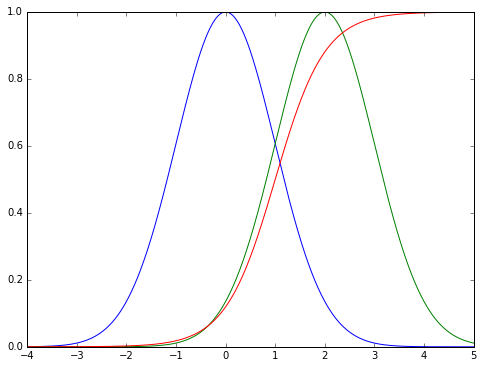

In [21]:
figsize(8, 6); plot(lxs,ys0); plot(lxs,ys1); plot(lxs,ys1/(ys0+ys1))

samples0 = norm.rvs(size=100)
samples1 = norm.rvs(size=100,loc=2)

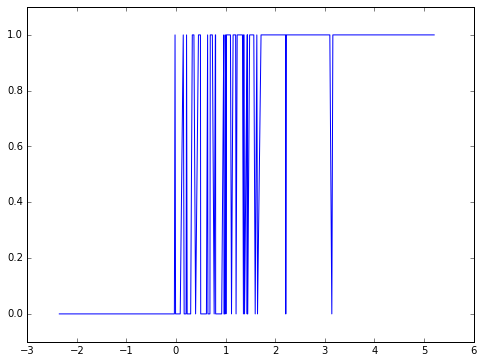

In [22]:
# target function (yes, it really is this messy)
data = c_[r_[samples0,samples1],r_[zeros(len(samples0)),ones(len(samples1))]]
order = argsort(data[:,0]); s = data[order,:]
ylim(-0.1,1.1); plot(s[:,0],s[:,1])

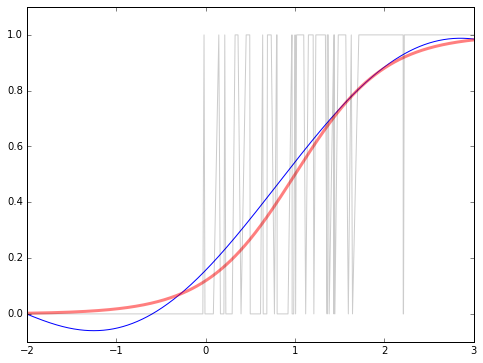

In [23]:
# simple polynomial fit
xlim((-2, 3)); ylim((-.1, 1.1))
fit = polyfit(data[:, 0], data[:, 1], 5)
plot(lxs, polyval(fit, lxs))
plot(lxs, posterior, color='r', linewidth=3, alpha=0.5)
plot(s[:, 0], s[:, 1], color="black", alpha=0.2)

In [24]:
import imgimg
import torch
from torch import nn
reload(imgimg)
def t(x): return torch.FloatTensor(x).cuda()
def n(x): return x.cpu().detach().numpy()

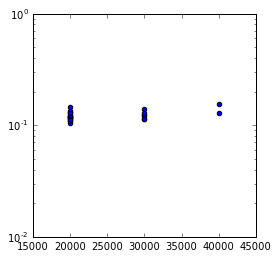

In [25]:
# simple neural network fit

def make_model():
    return nn.Sequential(nn.Linear(1, 4), nn.Sigmoid(), nn.Linear(4, 1), nn.Sigmoid())

xs = s[:,0].reshape(-1, 1); ys = s[:,1].reshape(-1, 1)
amlp = imgimg.AutoMLP(make_model, t(xs), t(ys), initial_bs=10, maxtrain=30000, decay=1e-5)
f = amlp.train()

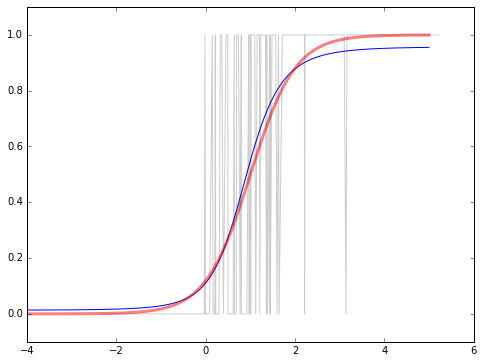

In [26]:
pred = n(f(t(lxs.reshape(-1, 1)))).ravel()
ylim((-.1, 1.1))
plot(lxs, pred)
plot(lxs, posterior, color='r', linewidth=3, alpha=0.5)
plot(s[:, 0], s[:, 1], color="black", alpha=0.2)

# Loss Functions

## Zero-One Loss

Above, we used a _zero-one loss_.  That is, we used a cost of 1 for an error and
a cost of 0 when there was no error.

In the general case, we have a 2D table of costs, saying how much of a penalty
we pay if the decision is one thing and the state of nature is another thing.

                   state 0     state 1

        action 0      0          1

        action 1      1          0

## Other Losses

These costs need not be at all like this.  In fact, costs frequently are
asymmetric.

                   state 0     state 1

        action 0      0         10

        action 1   1000          0


We call this matrix the _loss matrix_ and write the elements
as $\lambda_{ij}$, or a function $\Lambda(\alpha,\omega)$, which
is the cost of taking action $\alpha$ when the state of nature
is $\omega$.

## Relationship to Game Theory

These matrices are similar to payoff matrices in game theory:

- In Bayesian decision theory, nature picks a state at random and we take an action in response.
- In game theory, we need to make a decision and then someone else is going to make a decision in response.

## Risk = Expected Loss

In general, we want to minimize expected loss. 
We call expected loss the _risk_ of a decision.

Just like there are conditional probabilities, there
are conditional risks.

$$R(\alpha_1|x) = \lambda_{11} P(\omega_1|x) + \lambda_{12} P(\omega_2|x)$$

## Minimizing Expected Loss

We want to minimize overall risk, and for that we minimize risk at each point $x$.
To do that, we choose action $\alpha_1$ if the risk of that action is lower than
action $\alpha_2$ and vice versa.

\begin{eqnarray}
R(\alpha_1|x) & \leq & R(\alpha_2|x) \\\
\lambda_{11} P(\omega_1|x) + \lambda_{12} P(\omega_2|x) & \leq & 
\lambda_{21} P(\omega_1|x) + \lambda_{22} P(\omega_2|x)\\\
(\lambda_{12}-\lambda_{22}) P(\omega_2|x) & \leq &
(\lambda_{21}-\lambda_{11}) P(\omega_1|x) \\\
\end{eqnarray}

## Bayesian Loss Functions and Neural Network Loss Functions

Common loss functions used in DL:

- cross entropy between one-hot encoding of target and network output
- mean squared error between one-hot-encoding of target and network output

Both of those converge to posterior probabilities (though not equally well).

## Relationship to Bayesian Risk/Loss

MSE directly minimizes the empirical zero-one loss:

$\min_f \sum ||f(x_i) - y_i||^2$

You can directly minimize any other empirical loss $\cal L$, including the Bayes loss; you can even choose minimax criteria:

$\min_f \sum {\cal L}(f(x_i), y_i)$

## Weighted Samples

In many simple cases, you can just attach an importance $\gamma_i$ to each sample (implemented by multiplying the gradient):

$\min_f \sum \gamma_i ||f(x_i) - y_i||^2$



## Using DL Outputs

**Optimize Posteriors** If you optimize using zero-one loss (MSE), you can use network outputs as posterior probability estimates and then combine it with a typical loss function in a Bayesian framework.

**Optimize Losses** If you optimize using the actual domain-specific empirical loss, the network will give you a decision function that attempts to minimize that loss.

Asymptotically, the two approaches are equivalent. For finite sample sizes, they dedicate network resources differently.

## Rare, Important Classes

Let's say your training set consists of rare cases (e.g., car crashes) with a high associated loss. The classifier has a limited number of resources to model those cases (limited # hidden units, basis functions, support vectors).

**Optimize Posteriors** The classifier will devote its resources to improving decision boundaries between (otherwise) low-loss cases, resulting in poor performance.

**Optimize Losses** The classifer will minimize loss by devoting resources to improving decision boundaries between high-loss cases.

## Importance Sampling

Resample according to some importance distribution $p_r(x)$. Train on resampled samples $(x'_i, y'_i)$.

Use this loss:

$\min_f \sum \frac{1}{p_r(x'_i)} ||f(x'_i) - y'_i||^2$

The resulting classifier will estimate posteriors, yet minimize losses around where $p_r(x)$ concentrates.


## Human Losses

- "No human should ever be killed by the system."
- "We apply techniques from program correctness / formal methods to ensure that..."

Good idea?

Doesn't work:

- "never" = infinite cost
- infinite cost usually translates into "never decide this"
- applied to cars... never leave the house

## The Cost of Human Life

Government agencies:

- EPA: \$9 million / person
- FDA: \$7 million / person
- DOT: \$6 million / person
- Norway: \$3 million / person

Increase this "just to be safe"?



## Effects of Overestimating Losses

If you overestimate losses, you invest too many resources into preventing those losses.

The lack of those resources costs lives elsewhere.

E.g.:
- triple the value of human life under FDA regulations to \$20 million
- insurance/risk of drug development triples
- drug prices increase sharply meaning... fewer people can afford drug

# Summary

Optimal decision making under uncertainty is described by Bayesian Decision Theory.

Bayesian decision theory minimizes losses for given loss functions.

Bayesian decision theory requires both losses and priors.

If you make decisions some other way, you end up picking implicit losses and priors, probably worse than if you had spent a little time thinking about them.